In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl, pandas as pd, numpy as np, geopandas as gpd, pingouin as pin, matplotlib.pyplot as plt

import pysal as ps
from math import sqrt
import pylab
import ast
import networkx as nx

pd.set_option('precision', 2)
pd.options.display.float_format = '{:20.2f}'.format

In [2]:
import cityImage as ci
import ABManalysis as af

## 0.0 Loading Shapefile

In [4]:
# initialise path, names, etc.
city_name = 'London'
epsg = 27700
crs = {'init': 'epsg:'+str(epsg), 'no_defs': True}

In [5]:
input_path = 'Input/regionBasedNavigation/'+city_name
output_path = 'Outputs/regionBasedNavigation/'+city_name

edges = gpd.read_file(input_path+'_edges.shp', driver='ESRI Shapefile')
nodes = gpd.read_file(input_path+'_nodes.shp', driver='ESRI Shapefile')

nodes.index, edges.index = nodes.nodeID, edges.edgeID
nodes.index.name, edges.index.name = None, None

## 0.1 Loading  the simulation's volumes

In [5]:
columns = ['edgeID', 'AC', 'RB', 'BB','RBB']

runs = 5
df_list = []
for run in range(runs):
    df_tmp = pd.read_csv(input_path+'_PedSim_districts_'+str(run)+'.csv')
    df_tmp = df_tmp[columns]
    for n, c in enumerate(columns): 
        df_tmp.rename(columns={c: columns[n]+str(run)}, inplace=True)
    df_list.append(df_tmp)
    
df = pd.concat(df_list, axis = 1)
df['edgeID'] = df.edgeID0
for run in range(runs): 
    df.drop(['edgeID'+str(run)], axis = 1, inplace = True)

df_list = []
route_choice_models = ['AC', 'RB', 'BB','RBB']
for model in route_choice_models: 
    if model == 'RBB': 
        df_list.append(df[[col for col in df if col.startswith(model)]+['edgeID']])
    # 'RB' and 'RBB' same starting string
    else: 
        df_list.append(df[[col for col in df if (col.startswith(model) and not col.startswith('RBB'))]+['edgeID']])
    
# aggregate runs values
edges = af.aggregate_runs(df_list, route_choice_models, edges, ddof = 0)

## 0.2 Loading the simulation's resulting routes

In [6]:
route_choice_models = ['AC', 'RB', 'BB', 'RBB']
input_path_routes = 'Input/regionBasedNavigation/routes/'+city_name
routes_gdfs = []

for run in range(runs):
    run_gdf = gpd.read_file(input_path_routes+'_PedSim_district_routes_'+str(run)+'.shp').to_crs(epsg=epsg)

    for n, model in enumerate(route_choice_models):
        model_gdf = run_gdf[run_gdf.routeChoic == model].copy()
        if run == 0:
            routes_gdf = model_gdf.copy()
            routes_gdfs.append(model_gdf)
            continue
        routes_gdf = routes_gdfs[n].copy()
        routes_gdf = routes_gdf.append(model_gdf)
        routes_gdf.reset_index(inplace = True, drop=True)
        routes_gdf = routes_gdf.where(pd.notnull(routes_gdf), None)
        routes_gdfs[n] = routes_gdf

In [7]:
# preparing the routes gdf
for n, model in enumerate(route_choice_models): 
    routes_gdf = routes_gdfs[n].copy()
    routes_gdf['edgeIDs'] = routes_gdf.apply(lambda row: af.get_edgesID(row, routes_gdf.columns) , axis = 1)
    routes_gdf['O'] = routes_gdf['O'].astype(int)
    routes_gdf['D'] = routes_gdf['D'].astype(int)
    routes_gdfs[n] = routes_gdf

## 1 Computing statistics of each route
### 1.1 Distance walked along: pedestrian roads, major roads, natural barriers

In [8]:
edges['length'] = edges.geometry.length
col = ['ped', 'maj', 'bar'] 

if 'p_bool' not in edges.columns:
    edges['p_barr'] = [ast.literal_eval(i) for i in edges['p_barr']]
    edges['p_bool'] = edges.apply(lambda row: True if len(row['p_barr']) > 0 else False, axis = 1)
    
for n, model in enumerate(route_choice_models):
    routes_gdf = routes_gdfs[n].copy()
    routes_gdf = routes_gdf.assign(**dict.fromkeys(col, 0.0))
    routes_gdf['districts'] = None
    routes_gdf[['ped', 'maj', 'bar', 'districts']] = routes_gdf.apply(lambda row: af.regionBased_variables(row['edgeIDs'],
                                           row['geometry'], nodes,  edges), axis = 1, result_type='expand')
    routes_gdf['nr_dis'] = routes_gdf.apply(lambda row: af.count_regions(row, nodes), axis = 1)
    routes_gdfs[n] = routes_gdf

### 1.2 Deviation from the road-distance shortest path

In [7]:
graph = ci.graph_fromGDF(nodes, edges, nodeID = "nodeID")
distances = {}
routes_gdf = routes_gdfs[0].copy()
for row in routes_gdf.itertuples():
    source = routes_gdf.loc[row[0]]['O']
    target = routes_gdf.loc[row[0]]['D']
    distance  = nx.shortest_path_length(graph, source=source, target=target, weight='length', method='dijkstra')
    distances[str(source)+"-"+str(target)] = distance

## 2 Getting the statistics
### 2.1 Deviation from the road-distance shortest path

In [8]:
for n, model in enumerate(route_choice_models):
    print(model)
    routes_gdf = routes_gdfs[n].copy()
    print("median routes' lenght:", routes_gdf.geometry.length.median())
    print("mean routes' lenght:", routes_gdf.geometry.length.mean())
    routes_gdf['sp_dist'] = routes_gdf.apply(lambda row: distances[str(row['O'])+"-"+str(row['D'])], axis = 1)
    routes_gdf['sp_dev'] = routes_gdf.geometry.length/routes_gdf['sp_dist']
    print("median routes' deviation from SP", routes_gdf['sp_dev'].median())
    print()
    routes_gdfs[n] = routes_gdf

AC
median routes' lenght: 3033.3028170021416
mean routes' lenght: 3039.264961444328
median routes' deviation from SP 1.1351095121671326

RB
median routes' lenght: 3166.849947141335
mean routes' lenght: 3213.506307886658
median routes' deviation from SP 1.187451667428415

BB
median routes' lenght: 4312.932649067254
mean routes' lenght: 4450.003296760537
median routes' deviation from SP 1.6747762329498292

RBB
median routes' lenght: 3766.100410129489
mean routes' lenght: 3887.419799308302
median routes' deviation from SP 1.4314255124413122



### 2.2 Deviation per scenario vs the nr of districts traversed

In [9]:
for n, model in enumerate(route_choice_models):
    print(model)
    routes_gdf = routes_gdfs[n].copy()
    routes_gdf['nr_dis'] = np.where(routes_gdf['nr_dis']<=5, routes_gdf['nr_dis'], 5)
    print('1 district', routes_gdf[routes_gdf['nr_dis'] == 1]['sp_dev'].median())
    print('2 district', routes_gdf[routes_gdf['nr_dis'] == 2]['sp_dev'].median())
    print('3 district', routes_gdf[routes_gdf['nr_dis'] == 3]['sp_dev'].median())
    print('4 district', routes_gdf[routes_gdf['nr_dis'] == 4]['sp_dev'].median())
    print('5 district', routes_gdf[routes_gdf['nr_dis'] == 5]['sp_dev'].median())
    print( )
print()

AC
1 district 1.1095860140546419
2 district 1.1119009704793044
3 district 1.157914728754641
4 district 1.2196580938605757
5 district 1.2417119896312538

RB
1 district 1.113205369359694
2 district 1.1682438237242394
3 district 1.2266640383379444
4 district 1.2983450305515298
5 district 1.5163972753371644

BB
1 district 1.446652251993131
2 district 1.5303246719180619
3 district 1.709253517603799
4 district 1.8958516082132015
5 district 2.058654648521943

RBB
1 district 1.4045745650526644
2 district 1.403242416947949
3 district 1.4663756434510153
4 district 1.5894832725920907
5 district 1.8712796496416901




### 2.3 Deviation per scenario vs routes' length

In [10]:
for n, model in enumerate(route_choice_models):
    print(model)
    routes_gdf = routes_gdfs[n].copy()
    routes_gdf['length'] = routes_gdf.geometry.length
    print('correlation length and deviation :', np.corrcoef(routes_gdf['length'], routes_gdf['sp_dev'])[0][1])
    print('routes similar to shortest path', len(routes_gdf[routes_gdf['sp_dev'] < 1.10])/len(routes_gdf)*100,'%')
    print()
print()

AC
correlation length and deviation : 0.48663268075110605
routes similar to shortest path 40.0 %

RB
correlation length and deviation : 0.6107811851896702
routes similar to shortest path 27.68 %

BB
correlation length and deviation : 0.7335621873969734
routes similar to shortest path 4.53 %

RBB
correlation length and deviation : 0.6748408308965331
routes similar to shortest path 7.449999999999999 %




### *Saving and Loading*

In [11]:
# export routes
for n, model in enumerate(route_choice_models):
    routes_gdfs[n]['ds_str'] = routes_gdfs[n]['districts'].astype(str)
    routes_gdfs[n].drop(['districts', 'edgeIDs'], axis = 1, errors = 'ignore').to_file(
        output_path+'_'+model+'_routes.shp', driver='ESRI Shapefile')

In [6]:
## reload routes
routes_gdfs = []
route_choice_models = ['AC', 'RB', 'BB', 'RBB']
for n, model in enumerate(route_choice_models):
    routes_gdf = gpd.read_file(output_path+'_'+model+'_routes.shp', driver='ESRI Shapefile')
    routes_gdf['districts'] = [ast.literal_eval(i) for i in routes_gdf['ds_str']]
    routes_gdf['edgeIDs'] = routes_gdf.apply(lambda row: af.get_edgesID(row, routes_gdf.columns) , axis = 1)
    routes_gdfs.append(routes_gdf)

### 2.4 Significance test on road types portions
* Meters traversed along pedestrian roads
* Meters traversed along major roads
* Meters traversed along barriers

In [15]:
labels = ['ped', 'maj', 'bar'] 
titles = ['Pedestrian Roads', 'Major Roads', 'Natural Barriers']
routes_stats = af.generate_routes_stats(routes_gdfs, route_choice_models, labels, titles)

In [16]:
pin.pairwise_gameshowell(data = routes_stats[routes_stats.type == 'Pedestrian Roads'], dv= 'values', 
                         between = 'routeChoice', tail = 'two sided', effsize = 'cohen', alpha = 0.01)

,A,B,mean(A),mean(B),diff,se,tail,T,df,pval,cohen
0,AC,BB,0.17,0.21,-0.04,0.00,two sided,-15.54,19928.20,0.00,-0.22
1,AC,RB,0.17,0.19,-0.02,0.00,two sided,-7.01,19803.87,0.00,-0.10
2,AC,RBB,0.17,0.20,-0.03,0.00,two sided,-11.03,19722.79,0.00,-0.16
3,BB,RB,0.21,0.19,0.02,0.00,two sided,9.10,19965.96,0.00,0.13
4,BB,RBB,0.21,0.20,0.01,0.00,two sided,5.09,19927.79,0.00,0.07
5,RB,RBB,0.19,0.20,-0.01,0.00,two sided,-4.18,19990.52,0.00,-0.06


In [17]:
pin.pairwise_gameshowell(data = routes_stats[routes_stats.type == 'Major Roads'], dv= 'values', between = 'routeChoice', 
                        tail = 'two sided', effsize = 'hedges', alpha = 0.01)

,A,B,mean(A),mean(B),diff,se,tail,T,df,pval,hedges
0,AC,BB,0.29,0.25,0.04,0.00,two sided,15.20,18731.62,0.00,0.21
1,AC,RB,0.29,0.22,0.07,0.00,two sided,22.34,19291.85,0.00,0.32
2,AC,RBB,0.29,0.21,0.08,0.00,two sided,28.39,18202.99,0.00,0.40
3,BB,RB,0.25,0.22,0.02,0.00,two sided,8.70,19894.04,0.00,0.12
4,BB,RBB,0.25,0.21,0.04,0.00,two sided,15.08,19929.07,0.00,0.21
5,RB,RBB,0.22,0.21,0.01,0.00,two sided,5.56,19662.90,0.00,0.08


In [18]:
pin.pairwise_gameshowell(data = routes_stats[routes_stats.type == 'Natural Barriers'], dv= 'values', between = 'routeChoice', 
                        tail = 'two sided', effsize = 'hedges',  alpha = 0.01)

,A,B,mean(A),mean(B),diff,se,tail,T,df,pval,hedges
0,AC,BB,0.14,0.20,-0.06,0.00,two sided,-20.29,19977.27,0.00,-0.29
1,AC,RB,0.14,0.14,0.01,0.00,two sided,3.31,19870.71,0.01,0.05
2,AC,RBB,0.14,0.17,-0.02,0.00,two sided,-7.57,19962.63,0.00,-0.11
3,BB,RB,0.20,0.14,0.07,0.00,two sided,24.48,19952.13,0.00,0.35
4,BB,RBB,0.20,0.17,0.04,0.00,two sided,13.04,19996.04,0.00,0.18
5,RB,RBB,0.14,0.17,-0.03,0.00,two sided,-11.26,19969.05,0.00,-0.16


## 2. Volumes

### Saving volumes

In [19]:
edges.to_file(output_path+'_pedSim_RB.shp',  use_unicode=True, driver='ESRI Shapefile')

### 2.1 Statistics and scenarios' comparison 

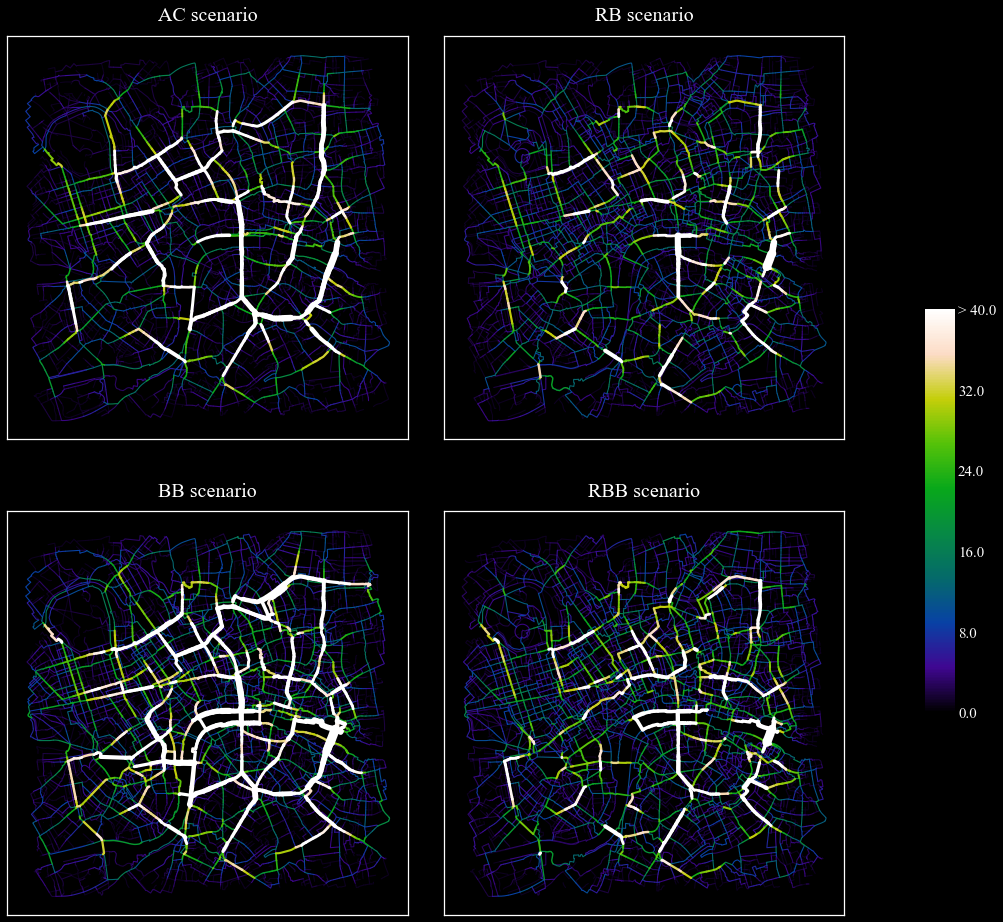

In [21]:
subtitles = ['AC scenario', 'RB scenario', 'BB scenario', 'RBB scenario']

norm = mpl.colors.Normalize(vmin=0, vmax= 40)
fig = ci.plot_gdf_grid(edges, columns = route_choice_models, cmap = ci.kindlmann(), norm = norm, titles = subtitles, cbar = True, cbar_ticks = 5,
        cbar_max_symbol = True, lw_factor = 0.07, axis_frame = True, black_background = True)

In [23]:
fig.savefig("Outputs/Figures/regionBasedNavigation/Fig7.pdf", bbox_inches='tight')

In [209]:
titles =['Angular change scenario','Region-based scenario',  'Barrier-based scenario', 'Region-Barrier based scenario']
num_trips = 2000

for n, model in enumerate(route_choice_models):
    print(titles[n]+' mean is ', edges[model].mean())
    print(titles[n]+' STD is ', edges[model].std())
    print(titles[n]+' max is ', edges[model].max())
    print()

Angular change scenario mean is  4.5095031055900625
Angular change scenario STD is  9.940338660881467
Angular change scenario max is  98.0

Region-based scenario mean is  5.377639751552795
Region-based scenario STD is  8.371470821571
Region-based scenario max is  125.0

Barrier-based scenario mean is  6.577577639751553
Barrier-based scenario STD is  11.711918001081232
Barrier-based scenario max is  131.0

Region-Barrier based scenario mean is  6.01472049689441
Region-Barrier based scenario STD is  9.139502146564853
Region-Barrier based scenario max is  128.0



### 2.2 Inequality - Gini Coefficient

In [28]:
sgs = []
for n, model in enumerate(route_choice_models):
    sg = ps.explore.inequality.gini.Gini(list(edges[model]))
    print(model, sg.g)

AC 0.7908405928848311
RB 0.7058912796121131
BB 0.7264655447218283
RBB 0.6743188781660826
